# Лабораторная работа №3

## Предметная область, источник и характер данных
Датасет представляет из себя набор данных, в котором содержится информация о различных характеристиках ириса, на основе которых можно предсказать его подвид. Ссылка на датасет: https://www.kaggle.com/datasets/uciml/iris

## Описание атрибутов
- Id: порядковый номер
- SepalLengthCm: длина чашелистика ириса в сантиметрах
- SepalWidthCm: ширина чашелистика ириса в сантиметрах
- PetalLengthCm: длина лепестка ириса в сантиметрах
- PetalWidthCm: ширина лепестка ириса в сантиметрах
- Species: подвид ириса

## Анализ данных
Задача анализа - классификация данных, а также предсказание подвида ириса по его другим характеристикам

## Удаление выбросов и пустых значений

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
%matplotlib inline
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn .tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC

df = pd.read_csv("./Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


Удалим столбик Id, он нам не пригодится

In [33]:
df = df.drop(columns=['Id'])
df.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Удалим пустые значения:

In [38]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Удалим выбросы:

In [41]:
for col in df.select_dtypes(include=['number']).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
    print(f"{col} - {outliers_count} выбросов")

df_filtered = df.copy()
for col in df_filtered.select_dtypes(include=['number']).columns:
    Q1 = df_filtered[col].quantile(0.25)
    Q3 = df_filtered[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_filtered = df_filtered[(df_filtered[col] >= lower_bound) & (df_filtered[col] <= upper_bound)]

SepalLengthCm - 0 выбросов
SepalWidthCm - 4 выбросов
PetalLengthCm - 0 выбросов
PetalWidthCm - 0 выбросов


In [43]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  146 non-null    float64
 1   SepalWidthCm   146 non-null    float64
 2   PetalLengthCm  146 non-null    float64
 3   PetalWidthCm   146 non-null    float64
 4   Species        146 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.8+ KB


## Классификация

Выбираем класс Species как целевой. Именно этот класс мы будем "предсказывать" на основе других данных.

In [54]:
class_distribution = df_filtered['Species'].value_counts()
print(class_distribution)

Species
Iris-virginica     50
Iris-versicolor    49
Iris-setosa        47
Name: count, dtype: int64


Данные сбалансированы. Поделим их на тестовые и тренировочные:

In [56]:
X = df_balanced.drop(columns='Species')
Y = df_balanced['Species']
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_tr, X_t, Y_tr, Y_t = train_test_split(X, Y, stratify=Y)

## kNN

Найдем оптимальный параметр:

In [64]:
knn = KNeighborsClassifier()
grid_params = {'n_neighbors': [i for i in range(1, 31)], 'weights': ['uniform', 'distance'], 'metric': ['minkowski', 'euclidean', 'manhattan']}
gs = GridSearchCV(knn, grid_params, scoring='accuracy', refit=True)
g_res = gs.fit(X_tr, Y_tr)
k = g_res.best_params_['n_neighbors']
metric = g_res.best_params_['metric']
weights = g_res.best_params_['weights']
g_res.best_params_

{'metric': 'minkowski', 'n_neighbors': 3, 'weights': 'uniform'}

Проведем классификацию:

In [67]:
knn = KNeighborsClassifier(n_neighbors=k, weights=weights).fit(X_tr, Y_tr)
predicted = knn.predict(X_t)

## Дерево решений

In [70]:
dt = DecisionTreeClassifier()
dt.fit(X_tr, Y_tr)
dt_predicted = dt.predict(X_t)

## Оценка классификации kNN
### Accuracy

In [76]:
r = 0
w = 0
for i, pos in enumerate(Y_t):
    if predicted[i] == pos:
        r += 1
    else:
        w += 1
accuracy = r / (r + w)
print(accuracy)
print(f"{accuracy * 100:.2f}%")

0.8947368421052632
89.47%


### Precision, Recall, F-measure

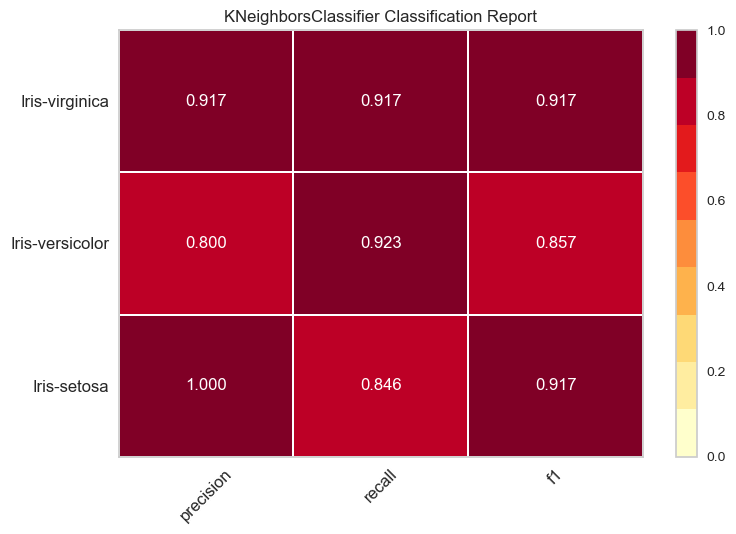

In [79]:
report = ClassificationReport(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## ROC

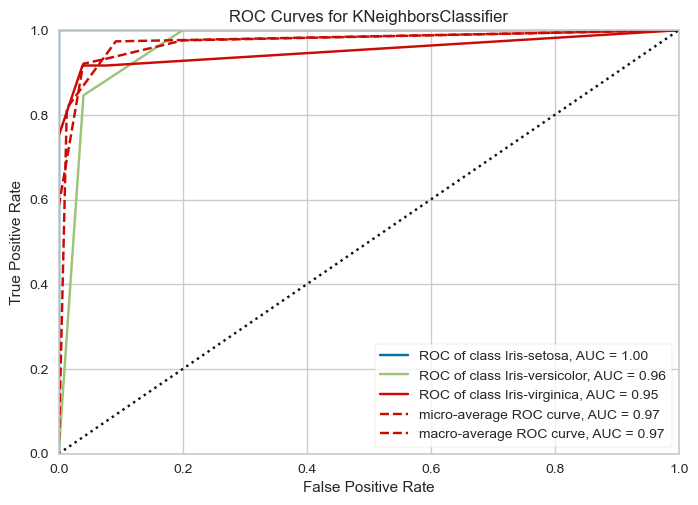

In [82]:
report = ROCAUC(knn, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## Оценка классификации деревом решений
### Accuracy

In [85]:
r = 0
w = 0
for i, pos in enumerate(Y_t):
    if dt_predicted[i] == pos:
        r += 1
    else:
        w += 1

accuracy = r / (r + w)
print(accuracy)
print(f"{accuracy * 100:.2f}%")

0.9210526315789473
92.11%


### Precision, Recall, F-measure

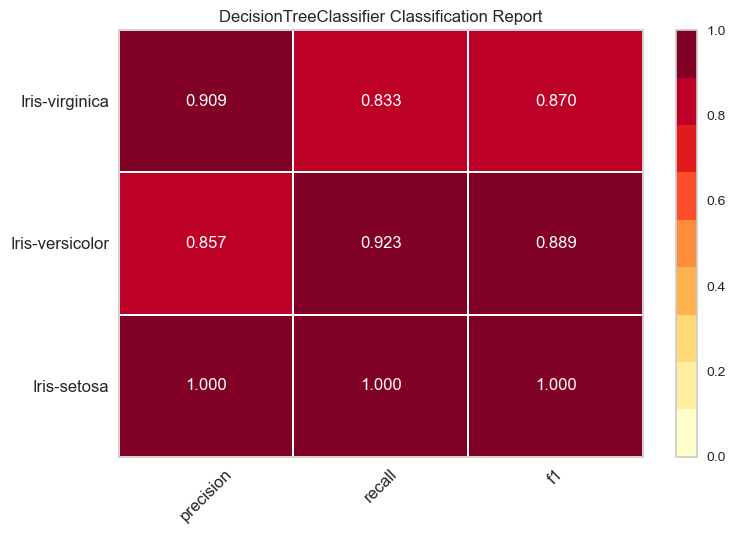

In [89]:
report = ClassificationReport(dt, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## ROC

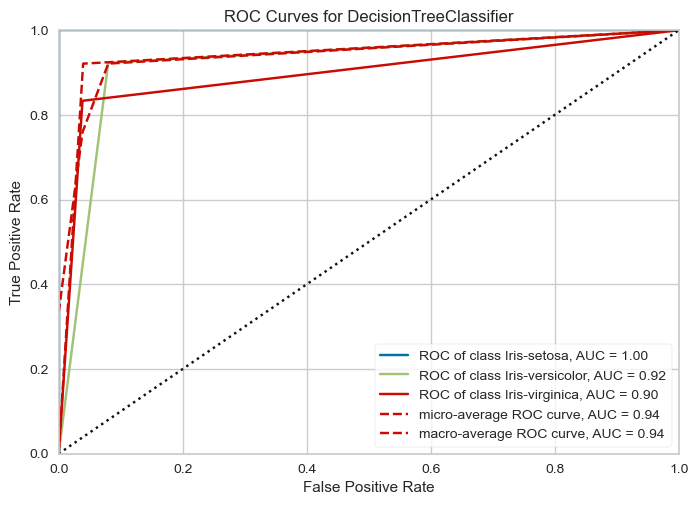

In [92]:
report = ROCAUC(dt, classes=encoder.classes_)
report.fit(X_tr, Y_tr)
report.score(X_t, Y_t)
report.show();

## Вывод
Во время выполнения данной лабораторной работы мы выбрали целевой класс для дальнейшей работы с ним, произвели классификацию, затем оценили результаты классификаций разными методами. Можно заметить, что подвид Iris-setosa является наиболее предсказуемым подвидом в данном датасете: при обеих методах точность его предсказания при ROC-оценке составила 1.00. Остальные же подвиды тоже являются достаточно предсказуемыми, минимальная точность предсказания 0.8 (для Iris-versicolor при Presicion-оценке метода kNN). В целом, имеются отличия при разных методах классификации, но они не слишком сильно различаются.